In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors

In [49]:
def CompDesc(smiles):
    # convert the smiles to rdkit mol objects
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    # add hydrogens to the mol objects
    mols = [Chem.AddHs(mol) for mol in mols]

    data = {'SMILES': smiles}
    df = pd.DataFrame(data)

    descriptors = ['MolWt', 'HeavyAtomCount', 'RingCount', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 
                   'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'NumHeteroatoms', 
                   'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumSaturatedCarbocycles', 
                   'NumSaturatedHeterocycles', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles']

    for desc in descriptors:
        df[desc] = df['SMILES'].apply(lambda x: getattr(Descriptors, desc)(Chem.MolFromSmiles(x)))

    return df

In [50]:
# load the data from the csv file
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# merge the train and test dataframes and let me know how many train rows and test rows there are
data = pd.concat([train, test])
print('Train rows: ', len(train))
print('Test rows: ', len(test))
print('Total rows: ', len(data))

# extract smiles 
smiles = data['SMILES']

data.head()

Train rows:  18582
Test rows:  4646
Total rows:  23228


,SMILES,LogVP,LogP,LogOH,LogBCF,LogHalfLife,BP,Clint,FU,LogHL,LogKmHL,LogKOA,LogKOC,MP,LogMolar
0,O=[N+]([O-])C1=NCC=NC1=NCC(O)CO,NaN,0.280391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O=C(O)CCCCBr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341322,NaN
2,CC(=O)OC1CCCCC1C(C)(C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335439,NaN
3,OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17,NaN,NaN,NaN,NaN,NaN,NaN
4,N#CCC(N)=O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.461147,0.857486


In [51]:
desc = CompDesc(smiles)
desc.head()

,SMILES,MolWt,HeavyAtomCount,RingCount,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumHeteroatoms,NumAromaticCarbocycles,NumAromaticHeterocycles,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumAliphaticCarbocycles,NumAliphaticHeterocycles
0,O=[N+]([O-])C1=NCC=NC1=NCC(O)CO,214.181,15,1,2,6,3,0,0,1,8,0,0,0,0,0,1
1,O=C(O)CCCCBr,181.029,8,0,1,1,4,0,0,0,3,0,0,0,0,0,0
2,CC(=O)OC1CCCCC1C(C)(C)C,198.306,14,1,0,2,1,0,1,1,2,0,0,1,0,1,0
3,OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1,383.517,27,4,1,6,5,2,1,2,6,2,0,0,1,0,2
4,N#CCC(N)=O,84.078,6,0,1,2,1,0,0,0,3,0,0,0,0,0,0


In [52]:
data = data.fillna(0.0)

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# If necessary, remove the 'SMILES' column before performing PCA
descriptors = desc.drop('SMILES', axis=1)

# Standardization of descriptors (it's a good practice before performing PCA)
scaler = StandardScaler()
standardized_descriptors = scaler.fit_transform(descriptors)

# Creation of a PCA object with the desired number of principal components (e.g., 10)
num_components = 10
pca = PCA(n_components=num_components)

# Training the PCA on the standardized dataset
principal_components = pca.fit_transform(standardized_descriptors)

# Initialize the explained variance
explained_variance = 0

# Add the new principal components to the DataFrame
for i in range(num_components):
    desc[f'PC{i+1}'] = principal_components[:, i]
    # calculate how many dimensions are needed to explain 70%, 80% and 90% of the variance
    explained_variance += pca.explained_variance_ratio_[i]
    if explained_variance >= 0.7 and explained_variance < 0.8:
        print(f'70% of the total variance is explained by the first {i+1} principal components')
    elif explained_variance >= 0.8:
        print(f'80% of the total variance is explained by the first {i+1} principal components')
        break

# Display the DataFrame with the new principal components
desc.head()

70% della varianza totale è spiegata dalle prime 3 componenti principali
70% della varianza totale è spiegata dalle prime 4 componenti principali
80% della varianza totale è spiegata dalle prime 5 componenti principali


,SMILES,MolWt,HeavyAtomCount,RingCount,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,...,NumAromaticHeterocycles,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumAliphaticCarbocycles,NumAliphaticHeterocycles,PC1,PC2,PC3,PC4,PC5
0,O=[N+]([O-])C1=NCC=NC1=NCC(O)CO,214.181,15,1,2,6,3,0,0,1,...,0,0,0,0,1,0.453884,-0.348375,2.058480,0.433486,0.232679
1,O=C(O)CCCCBr,181.029,8,0,1,1,4,0,0,0,...,0,0,0,0,0,-2.095742,-1.009450,1.182103,-0.215794,-0.232037
2,CC(=O)OC1CCCCC1C(C)(C)C,198.306,14,1,0,2,1,0,1,1,...,0,1,0,1,0,-0.346416,-2.886111,-0.346992,-0.895107,0.297706
3,OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1,383.517,27,4,1,6,5,2,1,2,...,0,0,1,0,2,4.089696,0.892949,-0.660238,2.118603,-1.588191
4,N#CCC(N)=O,84.078,6,0,1,2,1,0,0,0,...,0,0,0,0,0,-2.454172,-1.286462,0.929876,0.275478,0.253884


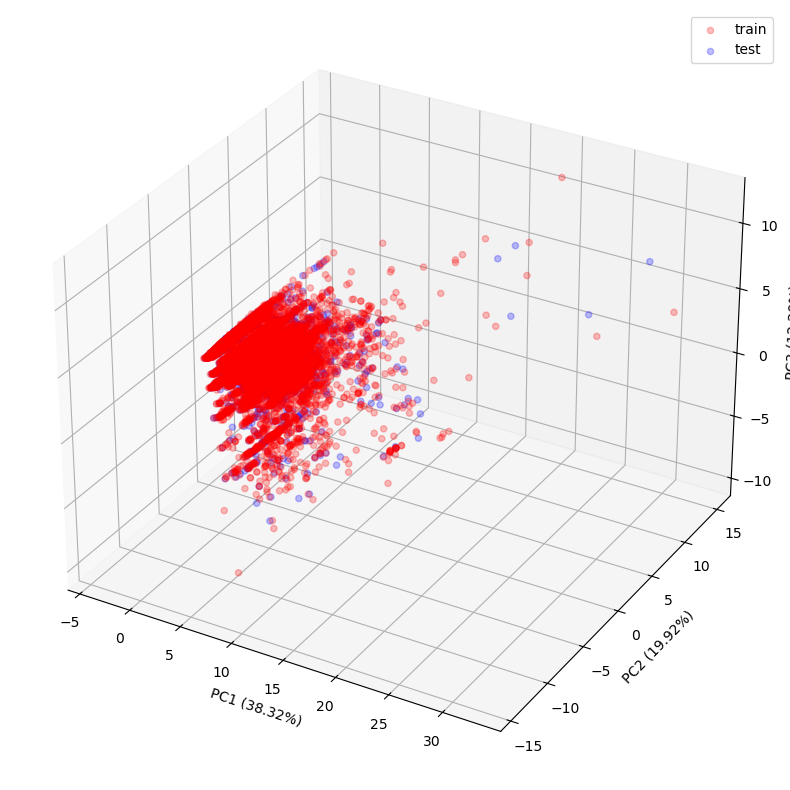

In [54]:
# plot in 3D the first 3 principal components
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(desc['PC1'][:18581], desc['PC2'][:18581], desc['PC3'][:18581], c='r', marker='o', alpha=0.25, label='train')
ax.scatter(desc['PC1'][18582:], desc['PC2'][18582:], desc['PC3'][18582:], c='b', marker='o', alpha=0.25,label='test')
ax.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
ax.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
ax.set_zlabel(f'PC3 ({round(pca.explained_variance_ratio_[2]*100, 2)}%)')
plt.tight_layout()
plt.legend()
plt.show()


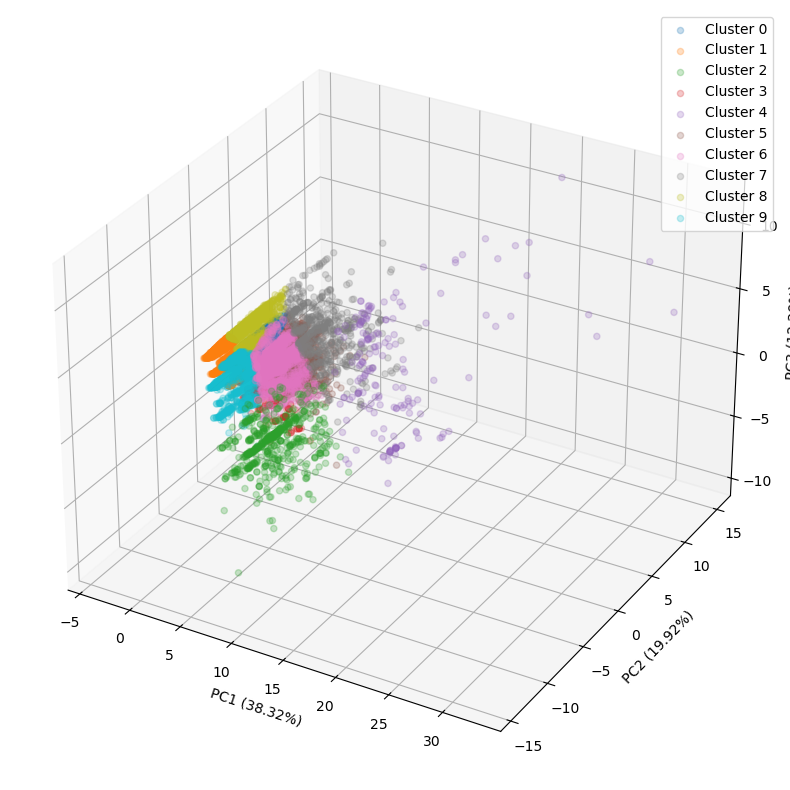

In [ ]:
# Perform kmeans clustering on the first 3 principal components
from sklearn.cluster import KMeans

# Create a KMeans object with the desired number of clusters (e.g., 3)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Train the KMeans model on the first 3 principal components
kmeans.fit(desc[['PC1', 'PC2', 'PC3']])
# Add the cluster labels to the DataFrame
desc['Cluster'] = kmeans.labels_

# Display the DataFrame with the cluster labels
desc.head()

# Save the centroids of the clusters
centroids = kmeans.cluster_centers_

# Plot in 3D the first 3 principal components with the cluster labels
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(num_clusters):
    ax.scatter(desc['PC1'][desc['Cluster'] == i], desc['PC2'][desc['Cluster'] == i], desc['PC3'][desc['Cluster'] == i], marker='o', alpha=0.25, label=f'Cluster {i}')
ax.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
ax.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
ax.set_zlabel(f'PC3 ({round(pca.explained_variance_ratio_[2]*100, 2)}%)')
plt.tight_layout()
plt.legend()
plt.show()

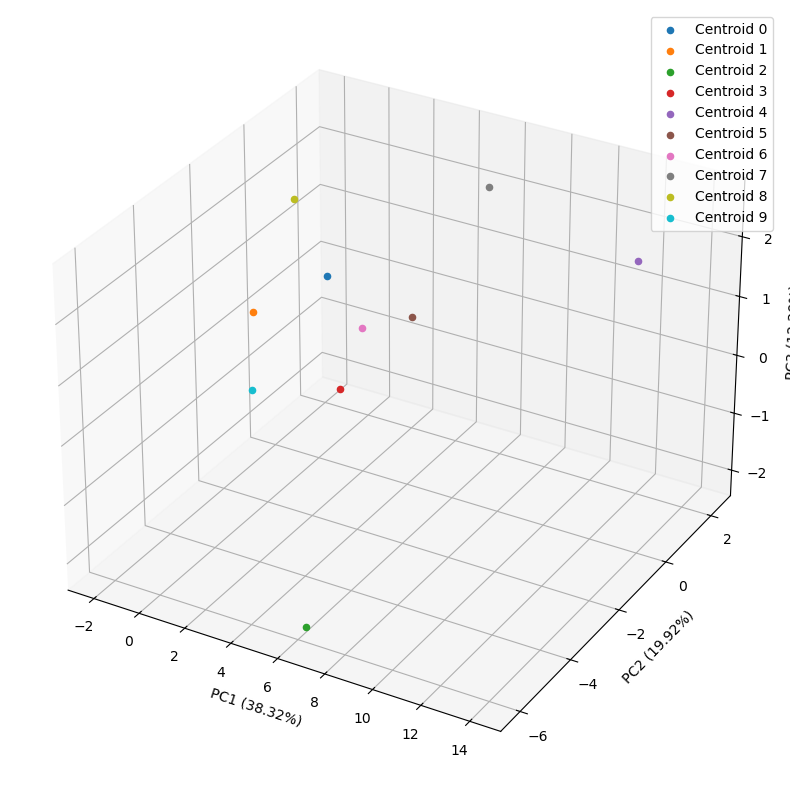

In [56]:
# plot the centroids of the clusters
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(num_cluster):
    ax.scatter(centroids[i][0], centroids[i][1], centroids[i][2], marker='o', label=f'Centroid {i}')
ax.set_xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
ax.set_ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
ax.set_zlabel(f'PC3 ({round(pca.explained_variance_ratio_[2]*100, 2)}%)')
plt.tight_layout()
plt.legend()
plt.show()

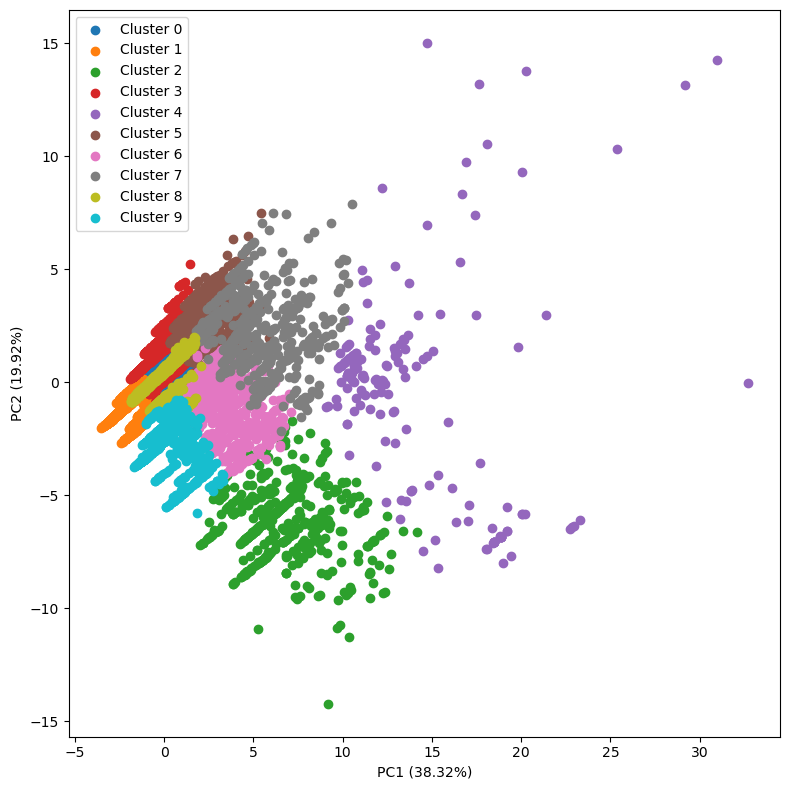

In [57]:
# plot the data in 2D using the first 2 principal components
fig = plt.figure(figsize=(8, 8))
for i in range(num_cluster):
    plt.scatter(desc['PC1'][desc['Cluster'] == i], desc['PC2'][desc['Cluster'] == i], label=f'Cluster {i}')
plt.xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
plt.ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
plt.tight_layout()
plt.legend()
plt.show()


In [58]:
# show the smiles corresponding to the centroids and save them in a variable
centroids_smiles = []

for i in range(num_cluster):
    print(f'Centroid {i} SMILES:')
    print(desc.iloc[(desc[['PC1', 'PC2', 'PC3']] - centroids[i]).pow(2).sum(1).idxmin(), 0])
    centroids_smiles.append(desc.iloc[(desc[['PC1', 'PC2', 'PC3']] - centroids[i]).pow(2).sum(1).idxmin(), 0])

Centroid 0 SMILES:
C/N=C(\O)N(C)/C(O)=N/c1cc(OC)ccc1F
Centroid 1 SMILES:
c1cn[nH]n1
Centroid 2 SMILES:
CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)/C(O)=N/C(C)(C)C
Centroid 3 SMILES:
Clc1cc(Cl)c(-c2cc(Cl)c(Cl)c(Cl)c2)cc1Cl
Centroid 4 SMILES:
COC1CC2CCC(C)C(O)(O2)C(=O)C(=O)N2CCCCC2C(=O)OC(C(C)CC2CCC(OCCO)C(OC)C2)CC(=O)C(C)C=C(C)C(O)C(OC)C(=O)C(C)CC(C)C=CC=CC=C1C
Centroid 5 SMILES:
CC(C)(Sc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1)Sc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1
Centroid 6 SMILES:
NC1=NCC(CN2CCN(c3ccc(F)cc3)CC2)O1
Centroid 7 SMILES:
COc1ncnc2c1ncn2C1OC(COC(=O)C(C)C)C(OC(=O)C(C)C)C1OC(=O)C(C)C
Centroid 8 SMILES:
CCC(CC)(C(=O)NC(N)=O)C(=O)OC(C)C
Centroid 9 SMILES:
ClC1C(Cl)C(Br)C(Cl)C(Br)C1Cl


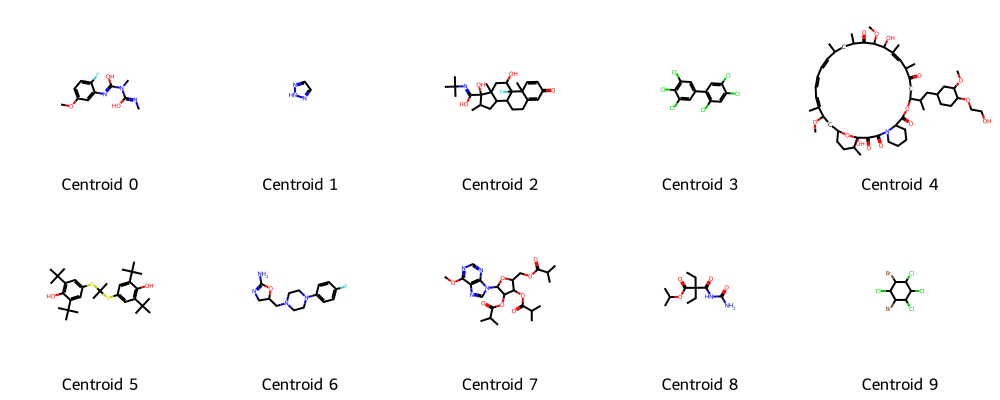

In [59]:
# visualize the centroid_smiles
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in centroids_smiles], molsPerRow=5, subImgSize=(200, 200), legends=[f'Centroid {i}' for i in range(num_cluster)])

In [60]:
# Perform t-SNE on my data
from sklearn.manifold import TSNE

# Create a TSNE object with the desired number of components (e.g., 2)
num_components = 2
tsne = TSNE(n_components=num_components, random_state=42)

# Train the TSNE model on the standardized dataset
tsne_components = tsne.fit_transform(standardized_descriptors)

# Add the new TSNE components to the DataFrame
desc['TSNE1'] = tsne_components[:, 0]
desc['TSNE2'] = tsne_components[:, 1]

# Display the DataFrame with the new TSNE components
desc.head()

,SMILES,MolWt,HeavyAtomCount,RingCount,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,...,NumAliphaticCarbocycles,NumAliphaticHeterocycles,PC1,PC2,PC3,PC4,PC5,Cluster,TSNE1,TSNE2
0,O=[N+]([O-])C1=NCC=NC1=NCC(O)CO,214.181,15,1,2,6,3,0,0,1,...,0,1,0.453884,-0.348375,2.058480,0.433486,0.232679,8,24.361141,-23.109318
1,O=C(O)CCCCBr,181.029,8,0,1,1,4,0,0,0,...,0,0,-2.095742,-1.009450,1.182103,-0.215794,-0.232037,1,-9.934049,-98.823517
2,CC(=O)OC1CCCCC1C(C)(C)C,198.306,14,1,0,2,1,0,1,1,...,1,0,-0.346416,-2.886111,-0.346992,-0.895107,0.297706,9,37.889423,-97.588264
3,OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1,383.517,27,4,1,6,5,2,1,2,...,0,2,4.089696,0.892949,-0.660238,2.118603,-1.588191,6,72.273689,-7.494314
4,N#CCC(N)=O,84.078,6,0,1,2,1,0,0,0,...,0,0,-2.454172,-1.286462,0.929876,0.275478,0.253884,1,-22.877426,-93.516602


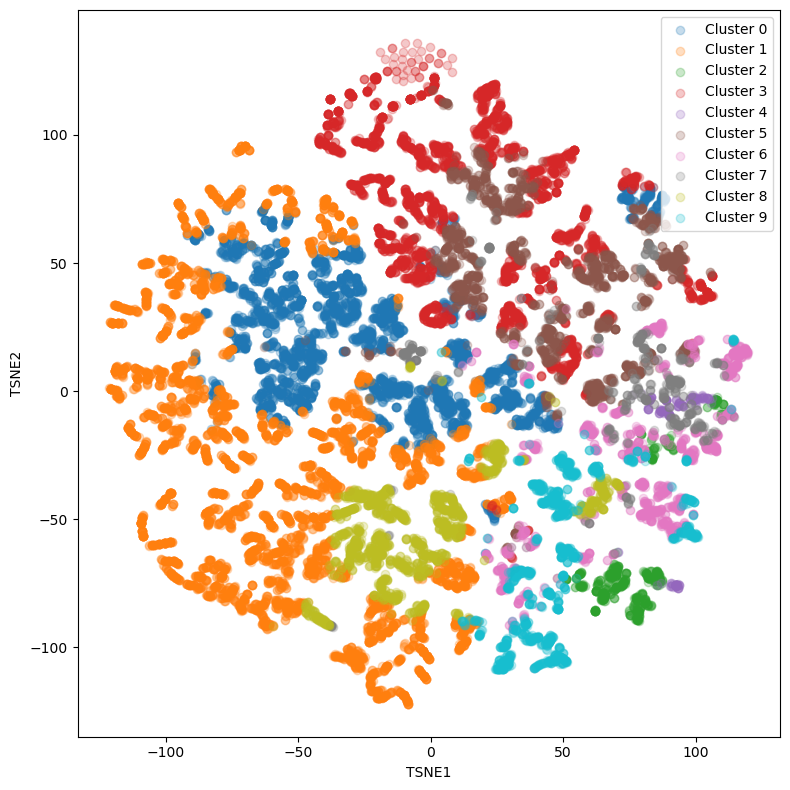

In [61]:
# plot in 2D the first 2 tsne components
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
for i in range(num_cluster):
    ax.scatter(desc['TSNE1'][desc['Cluster'] == i], desc['TSNE2'][desc['Cluster'] == i], marker='o', alpha=0.25, label=f'Cluster {i}')
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
plt.tight_layout()
plt.legend()
plt.show()


In [62]:
# calculate rdkit morgan fingerprints
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in mols]

# convert the rdkit morgan fingerprints to numpy arrays
np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

# convert the numpy arrays to a pandas dataframe
fps_df = pd.DataFrame(np_fps)

In [63]:
fps_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


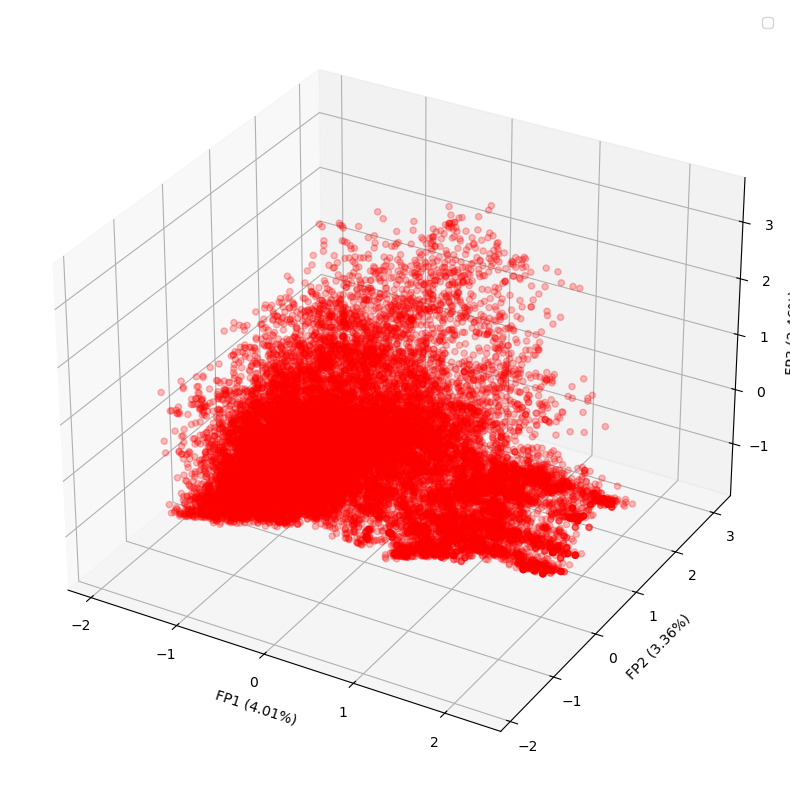

In [64]:
# perform pca on the morgan fingerprints
num_componenti = 10
pca = PCA(n_components=num_componenti)

componenti_principali = pca.fit_transform(fps_df)

varianza_spiegata = 0

for i in range(num_componenti):
    data[f'FP{i+1}'] = componenti_principali[:, i]
    # calcola quante dimensioni servono per spiegare il 70, 80 e 90% della varianza
    varianza_spiegata += pca.explained_variance_ratio_[i]
    if varianza_spiegata >= 0.7 and varianza_spiegata < 0.8:
        print(f'70% della varianza totale è spiegata dalle prime {i+1} componenti principali')
    elif varianza_spiegata >= 0.8:
        print(f'80% della varianza totale è spiegata dalle prime {i+1} componenti principali')
        break

data.head()

# plot in 3D the first 3 principal components
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['FP1'], data['FP2'], data['FP3'], c='r', marker='o', alpha=0.25)
ax.set_xlabel(f'FP1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)')
ax.set_ylabel(f'FP2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)')
ax.set_zlabel(f'FP3 ({round(pca.explained_variance_ratio_[2]*100, 2)}%)')
plt.tight_layout()
plt.legend()
plt.show()


In [65]:
# calculate the tanioto similarity between the fingerprints
tanioto_sim = []
for i in range(len(np_fps)):
    for j in range(len(np_fps)):
        tanioto_sim.append(DataStructs.TanimotoSimilarity(fps[i], fps[j]))

# convert the tanioto similarity to a numpy array
np_tanioto_sim = np.array(tanioto_sim)

# convert the numpy array to a pandas dataframe
tanioto_sim_df = pd.DataFrame(np_tanioto_sim.reshape(len(fps), len(fps)))


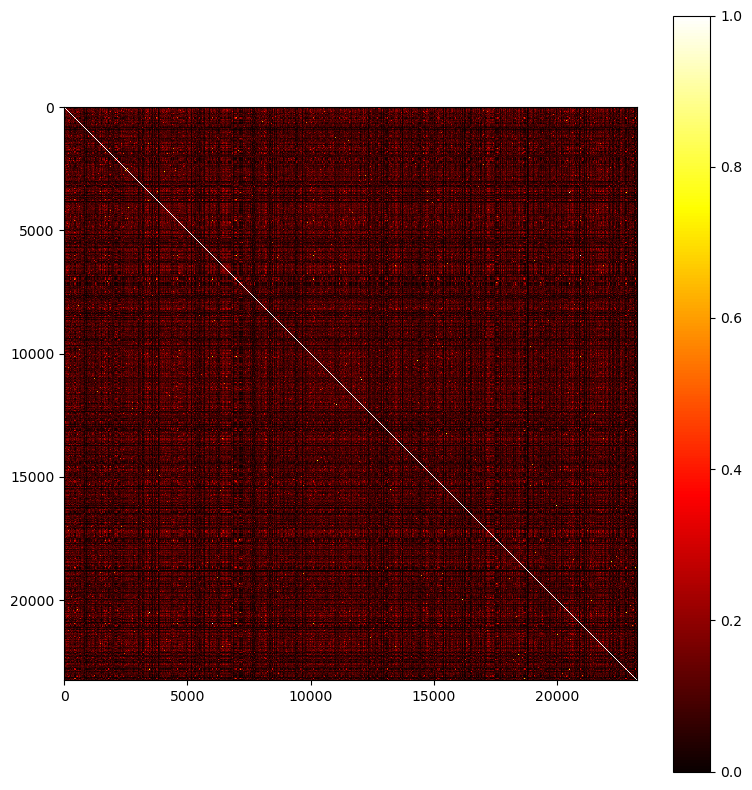

In [66]:
# plot the tanioto similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(tanioto_sim_df, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.tight_layout()
plt.show()